In [1]:
import sys 
sys.path.append('/Users/omid/Documents/GitHub/Causality/Quantum_RCC/Scripts')
import os
import pandas as pd
import numpy as np
import networkx as nx
from scipy import linalg as la
import scipy as sp
import random
import collections
import time
import torch as th; import torch; from torch.utils.data import DataLoader; import torch.nn as nn; import torch.nn.functional as F
import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import modAL
import copy
import IPython
np.set_printoptions(precision=3)
from sklearn.metrics import confusion_matrix


import utilities_functions as uFun
import distance_functions as dFun
import rcc_functions as rcc
import activeLearning_functions as alFun
import simulator_functions2 as simFun
import channel_functions2 as chFun
import pruning_functions2 as prFun2

In [2]:
#adjacencies_tr, adjacencies_va, adjacencies_te = uFun.split_1cc_dags(adjancencies_path='../Data/DAGs/multi_8node/all.txt', saving_paths=[f'../Data/DAGs/multi_8node/{}.txt' for subset in subsets],)

n_nodes = 8
n_points = 500
split_subsets = ['train', 'valid', 'test'] 

adjacencies_base = [
    th.tensor([[0, 0, 0], [0, 0, 0], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 0], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 0], [0, 0, 0], [0, 1, 0]]), 
    th.tensor([[0, 0, 0], [1, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 1], [0, 0, 1], [0, 0, 0]]), 
    th.tensor([[0, 1, 1], [0, 0, 0], [0, 1, 0]]), 
    th.tensor([[0, 0, 1], [1, 0, 1], [0, 0, 0]]),
]

#n_RandComps=50; data_dim=3; scales = list(np.logspace(-1.2, +1.2, 5, True))
#featurizer_obj = rcc.featurizer(n_RandComps=n_RandComps, scales=scales, data_dim=data_dim)
#uFun.object_saver(featurizer_obj, 'featurizer')
featurizer_obj = uFun.object_loader('featurizer')

#param_dict = generate_parameters(n_nodes)
#uFun.save_as_pickle(param_dict, 'param_dict.pickle')
param_dict = uFun.load_pickle('param_dict.pickle')


list_ijk = uFun.get_list_ijk(n_nodes)


In [3]:
#model_path = 'simulator'
#data_tr = th.load(f'ch_org_multi8node_train.pt')
#data_va = th.load(f'ch_org_multi8node_valid.pt')
#simulator = simFun.nn_simulator(n_nodes=8,batch_size=100,n_epochs=1000,lr=1e-4,patience=100,dim_noise=3,)
#simulator.reset_parameters()
#df_prog = simulator.fit(data_tr=data_tr, data_va=data_va, saving_path=model_path)
#simulator.re_load(model_path)

model_path = 'simulator_ijk'
data_tr = th.load(f'ch_org_multibase.pt')
data_va = th.load(f'ch_org_multi8node_valid.pt')
simulator = simFun.nn_simulator(n_nodes=8, batch_size=100, n_epochs=1000,lr=1e-4,patience=100,dim_noise=20,)
simulator.reset_parameters()
#df_prog = simulator.fit_ijk(data_tr=data_tr, data_va=data_va, list_ijk=uFun.get_list_ijk(8),saving_path=model_path,)
simulator.re_load(model_path)

index = 1
dataset_te, adjacencies_te = th.load(f'ch_org_multi8node_test.pt')
data_true = dataset_te[index]
data_pred = simulator.forward(gen_size=n_points, adjacency_matrix=adjacencies_te[index].type(th.int64))
dFun.MMDloss(n_points)(data_pred, data_true)


tensor(0.0356, grad_fn=<SumBackward0>)

### Generate and Simulate channel datasets

In [ ]:
##########################################################
# ch org multibase
##########################################################
n_samples = 2688
generator = chFun.genDataChannels(param_dict=param_dict)
container_d = th.zeros((n_samples, n_points, 3*3), dtype=th.float32)
container_a = th.zeros((n_samples, 3, 3), dtype=th.float32)
index_sample = 0
for i in range(n_nodes):
    for j in range(n_nodes):
        for k in range(n_nodes):
            if (i-j)*(j-k)*(k-i):
                for A_base in adjacencies_base:
                    adjacency_matrix = uFun.embed_graph(i, j, k, A_base, n_nodes)
                    #ch_data = simulator(n_points, adjacency_matrix).detach()
                    ch_data = generator.generate(adjacency_matrix=adjacency_matrix.numpy(), numRuns=n_points)
                    ch_data = th.concat((ch_data[:, 3*(i):3*(i+1)], ch_data[:, 3*(j):3*(j+1)], ch_data[:, 3*(k):3*(k+1)]), dim=1)
                    container_d[index_sample] = ch_data
                    container_a[index_sample] = A_base
                    index_sample += 1
                    print(index_sample)
ch_container = (container_d, container_a)
th.save(ch_container, f'ch_org_multibase.pt')

##########################################################
# ch org multi8node
##########################################################
generator = chFun.genDataChannels(param_dict=param_dict)
for subset in split_subsets:
    index_sample = 0
    container_a = th.tensor(np.array([A.reshape(8,8) for A in np.loadtxt(f'../Data/DAGs/multi_8node/{subset}.txt')]).astype(int))
    n_samples = len(container_a)
    container_d = th.zeros((n_samples, n_points, 3*8), dtype=th.float32)
    for adjacency_matrix in container_a:
        ch_data = generator.generate(adjacency_matrix=adjacency_matrix.numpy(), numRuns=n_points)
        container_d[index_sample] = ch_data
        index_sample += 1
    ch_container = (container_d, container_a)
    th.save(ch_container, f'ch_org_multi8node_{subset}.pt')

##########################################################
# ch sim multibase (not needed anymore)
##########################################################
n_samples = 2688
container_d = th.zeros((n_samples, n_points, 3*3), dtype=th.float32)
container_a = th.zeros((n_samples, 3, 3), dtype=th.float32)
index_sample = 0
for i in range(n_nodes):
    for j in range(n_nodes):
        for k in range(n_nodes):
            if (i-j)*(j-k)*(k-i):
                for A_base in adjacencies_base:
                    adjacency_matrix = uFun.embed_graph(i, j, k, A_base, n_nodes)
                    ch_data = simulator(n_points, adjacency_matrix).detach()
                    #ch_data = generator.generate(adjacency_matrix=adjacency_matrix.numpy(), numRuns=n_points)
                    ch_data = th.concat((ch_data[:, 3*(i):3*(i+1)], ch_data[:, 3*(j):3*(j+1)], ch_data[:, 3*(k):3*(k+1)]), dim=1)
                    container_d[index_sample] = ch_data
                    container_a[index_sample] = A_base
                    index_sample += 1
ch_container = (container_d, container_a)
th.save(ch_container, f'ch_sim_multibase.pt')

##########################################################
# ch sim multi8node
##########################################################
for subset in split_subsets:
    index_sample = 0
    container_a = th.tensor(np.array([A.reshape(8,8) for A in np.loadtxt(f'../Data/DAGs/multi_8node/{subset}.txt')]).astype(int))
    n_samples = len(container_a)
    container_d = th.zeros((n_samples, n_points, 3*8), dtype=th.float32)
    for adjacency_matrix in container_a:
        ch_data = simulator(n_points, adjacency_matrix).detach()
        container_d[index_sample] = ch_data
        index_sample += 1
    ch_container = (container_d, container_a)
    th.save(ch_container, f'ch_sim_multi8node_{subset}.pt')


### Featurize the channel datasets

In [ ]:
##########################################################
# kme org multibase
##########################################################
kme_container = rcc.kme_featurizer(
    ch_container_path = 'ch_org_multibase.pt', 
    featurizer_obj    = featurizer_obj, 
    scenario          = 'multi_base', 
    quad_labeling     = True,
    saving_path       = 'kme_org_multibase.pt',
)

##########################################################
# kme org multi8node
##########################################################
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = f'ch_org_multi8node_{subset}.pt', 
        featurizer_obj    = featurizer_obj, 
        scenario          = 'multi_8node', 
        quad_labeling     = True,
        saving_path       = f'kme_org_multi8node_{subset}.pt',
    )

##########################################################
# kme sim multi8node
##########################################################
for index_set, subset in enumerate(split_subsets):
    kme_container = rcc.kme_featurizer(
        ch_container_path = f'ch_sim_multi8node_{subset}.pt', 
        featurizer_obj    = featurizer_obj, 
        scenario          = 'multi_8node', 
        quad_labeling     = True,
        saving_path       = f'kme_sim_multi8node_{subset}.pt',
    )

### Convert KMEs to DataFrame

In [62]:
df_org_ba = rcc.container_to_df(f'kme_org_multibase.pt', 'multi_base', return_unique=False)
df_org_tr = rcc.container_to_df(f'kme_org_multi8node_train.pt', 'multi_8node', return_unique=True)
df_org_va = rcc.container_to_df(f'kme_org_multi8node_valid.pt', 'multi_8node', return_unique=True)
df_org_te = rcc.container_to_df(f'kme_org_multi8node_test.pt',  'multi_8node', return_unique=True)

#df_sim_ba = rcc.container_to_df(f'kme_sim_multibase.pt', 'multi_base', return_unique=False)
df_sim_tr = rcc.container_to_df(f'kme_sim_multi8node_train.pt', 'multi_8node', return_unique=True)
df_sim_va = rcc.container_to_df(f'kme_sim_multi8node_valid.pt', 'multi_8node', return_unique=True)
df_sim_te = rcc.container_to_df(f'kme_sim_multi8node_test.pt',  'multi_8node', return_unique=True)

### Train a Causal CLF
- Training data = two sets (org_multibase plus sim_multi8node_train)
- Test data = one set (org_multi8node_test)

In [63]:
df_tr = pd.concat([df_org_ba, df_sim_tr], axis=0)
#df_tr = pd.concat([df_org_ba, df_sim_tr, df_sim_va, df_sim_te], axis=0)

df_te = df_org_te
x_tr, y_tr = df_tr.values[:, 2:], df_tr.values[:, 1]
x_te, y_te = df_te.values[:, 2:], df_te.values[:, 1]

clf = MLPClassifier(
    hidden_layer_sizes=(300, 100),  
    #activation='tanh',
    learning_rate_init=1e-4,
    validation_fraction=0.2, 
    #alpha=1e-2, 
    #batch_size = 50,
    n_iter_no_change=30,
    early_stopping=True,
    max_iter=1000000, 
    verbose=1,
).fit(x_tr, y_tr)

uFun.object_saver(clf, 'causal_clf1')
#uFun.object_saver(clf, 'causal_clf2')

confusion_matrix(y_te, clf.predict(x_te), labels=[1,2,0], normalize='true')

Iteration 1, loss = 0.52556772
Validation score: 0.794225
Iteration 2, loss = 0.45692049
Validation score: 0.803501
Iteration 3, loss = 0.42957273
Validation score: 0.813596
Iteration 4, loss = 0.40817845
Validation score: 0.829263
Iteration 5, loss = 0.38722290
Validation score: 0.839392
Iteration 6, loss = 0.37032930
Validation score: 0.841457
Iteration 7, loss = 0.35273349
Validation score: 0.842505
Iteration 8, loss = 0.33821787
Validation score: 0.841358
Iteration 9, loss = 0.32553540
Validation score: 0.845193
Iteration 10, loss = 0.31055240
Validation score: 0.863811
Iteration 11, loss = 0.29993326
Validation score: 0.882690
Iteration 12, loss = 0.28647638
Validation score: 0.891737
Iteration 13, loss = 0.27879241
Validation score: 0.889147
Iteration 14, loss = 0.26766838
Validation score: 0.892327
Iteration 15, loss = 0.25723898
Validation score: 0.891475
Iteration 16, loss = 0.25212527
Validation score: 0.900226
Iteration 17, loss = 0.24155546
Validation score: 0.905012
Iterat

Iteration 140, loss = 0.05902795
Validation score: 0.957062
Iteration 141, loss = 0.06222369
Validation score: 0.922056
Iteration 142, loss = 0.06797478
Validation score: 0.952178
Iteration 143, loss = 0.05643791
Validation score: 0.953227
Iteration 144, loss = 0.06527532
Validation score: 0.959422
Iteration 145, loss = 0.06254078
Validation score: 0.956734
Iteration 146, loss = 0.05296747
Validation score: 0.960798
Iteration 147, loss = 0.05954561
Validation score: 0.921040
Iteration 148, loss = 0.06069369
Validation score: 0.959487
Iteration 149, loss = 0.05680875
Validation score: 0.959913
Iteration 150, loss = 0.06155038
Validation score: 0.961716
Iteration 151, loss = 0.05600218
Validation score: 0.957357
Iteration 152, loss = 0.05587292
Validation score: 0.958963
Iteration 153, loss = 0.06094208
Validation score: 0.958176
Iteration 154, loss = 0.05143465
Validation score: 0.950638
Iteration 155, loss = 0.05830136
Validation score: 0.909174
Iteration 156, loss = 0.05335007
Validat

array([[0.78 , 0.116, 0.104],
       [0.071, 0.847, 0.082],
       [0.119, 0.155, 0.726]])

Average wrong predictions on 135 DAGs => 
Raw (no post-processing): 6.652
Percentile: 3.644
Optimal percentile: 93.66666666666667
Optimal n_wrongs:   3.6444444444444444


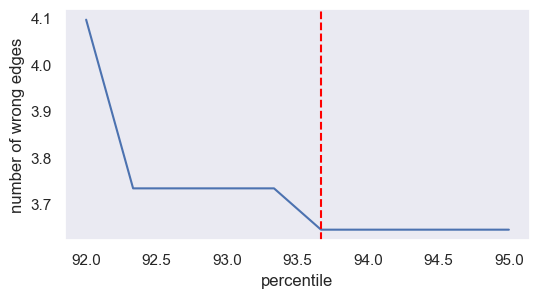

In [65]:
kme_container = th.load(f'kme_org_multi8node_valid.pt')
clf = uFun.object_loader('causal_clf1')

percentile_list = list(np.linspace(92, 95, 10))
nWrongs_list    = [] 
for percentile in percentile_list:
    df_preds = uFun.clf_evaluator_meta(
        kme_container=kme_container,
        clf=clf,
        n_DAGs=-1,
        percentile=percentile,
        predict_both_directions=True,
        saving_path=None,
    )
    nWrongs = df_preds['nWrongs_percentile'].mean()
    nWrongs_list.append(nWrongs)

percentile_opt = percentile_list[np.argmin(nWrongs_list)]
nWrongs_opt = nWrongs_list[np.argmin(nWrongs_list)]
print(f'Optimal percentile: {percentile_opt}\nOptimal n_wrongs:   {nWrongs_opt}')

fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(percentile_list, nWrongs_list)
ax.axvline(x=percentile_opt, color='red', linestyle='--')
ax.set_xlabel('percentile')
ax.set_ylabel('number of wrong edges')
plt.show()
plt.close()

In [76]:
kme_container = th.load(f'kme_org_multi8node_valid.pt')
clf = uFun.object_loader('causal_clf1')

percentile_opt = 92.66666666666667

df_preds = uFun.clf_evaluator_meta(
    kme_container=kme_container,
    clf=clf,
    n_DAGs=-1,
    percentile=percentile_opt,
    predict_both_directions=True,
    saving_path=None,
)
#percentile_opt = percentile_list[np.argmin(nWrongs_list)]
#nWrongs_opt = nWrongs_list[np.argmin(nWrongs_list)]
#print(f'Optimal percentile: {percentile_opt}\nOptimal n_wrongs:   {nWrongs_opt}')

df_preds.head(3)

Average wrong predictions on 135 DAGs => 
Raw (no post-processing): 6.652
Percentile: 3.733


,nWrongs_raw,nWrongs_percentile,nEdges_true,nEdges_pred,confusion,A_true,A_pred,A_binarized,A_percentile
0,8,4,5,11,"[[0.7391304347826086, 0.0, 0.2608695652173913]...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."
1,8,3,6,14,"[[0.6363636363636364, 0.18181818181818182, 0.1...","[[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.0, 0.597725829240272, 0.7801710073028096, ...","[[0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, ...","[[0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."
2,8,4,5,11,"[[0.7391304347826086, 0.0, 0.2608695652173913]...","[[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0....","[[0.0, 0.9935244859206134, 0.9363987492281391,...","[[0, 1, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, ...","[[0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."


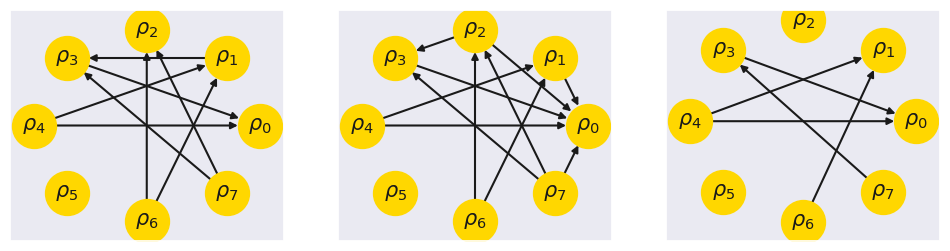

In [77]:
i=6
A_true = df_preds['A_true'].tolist()[i]
A_pred = df_preds['A_pred'].tolist()[i]
A_perc = df_preds['A_percentile'].tolist()[i]
uFun.graph_plotter(A_true, A_pred, A_perc)

In [215]:
percentile_opt = 70.51020408163265
lambda_opt = 0.0007208715033782136

simulator_path = 'simulator_ijk'
shallow_simulator = simFun.nn_simulator(n_nodes=8, batch_size=100, n_epochs=1000,lr=1e-4,patience=100,dim_noise=20,)

container_d = th.load(f'ch_org_multi8node_valid.pt')[0]
kme_container = th.load(f'kme_org_multi8node_valid.pt')

df_preds = uFun.clf_evaluator_meta(
    kme_container = kme_container, 
    clf           = clf, 
    n_DAGs        = 10,
    percentile    = percentile_opt,
    predict_both_directions=True,
    saving_path   = None,
)
df_preds['A_hill'] = None


for index, row in df_preds.iterrows():
    data_true = container_d[index]
    A_pred = row['A_pred'] 
    #A_pred = row['A_percentile']
    A_hill = hill_climbing(
        data_true=data_true, 
        A_pred=A_pred,
        penalty_weight=lambda_opt,
        n_runs=3,
        add=False,
        remove=True,
        shallow_simulator=shallow_simulator,
        simulator_path=simulator_path,
    )[0]
    
    df_preds.at[index, 'A_hill'] = A_hill
    df_preds.loc[index, 'nWrongs_hill'] = int(np.abs(row['A_true']-A_hill).sum())

IPython.display.clear_output(wait=True)
nWrongs_raw = df_preds['nWrongs_raw'].mean()
nWrongs_percentile = df_preds['nWrongs_percentile'].mean()
nWrongs_hill = df_preds['nWrongs_hill'].mean()

print('Average Wrong Perdictions:\nRaw        => {}\nPercentile => {}\nHill-Climb => {}'.format(nWrongs_raw, nWrongs_percentile, nWrongs_hill))

Average Wrong Perdictions:
Raw        => 6.6
Percentile => 6.6
Hill-Climb => 5.6


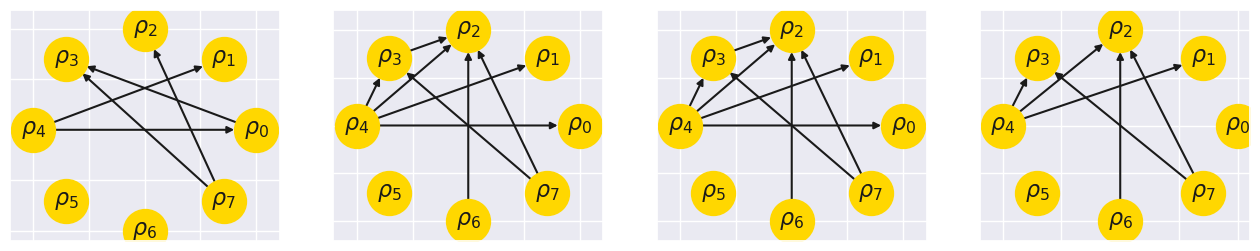

In [218]:
i=0
A_true = df_preds['A_true'].tolist()[i]
A_pred = df_preds['A_pred'].tolist()[i]
A_perc = df_preds['A_percentile'].tolist()[i]
A_hill = df_preds['A_hill'].tolist()[i]
uFun.graph_plotter(A_true, A_pred, A_perc, A_hill)